In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
%load_ext autoreload

In [3]:
import os
import argparse
import json
import cv2
from keras.models import load_model
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [11]:
import time
from pathlib import Path

In [4]:
%autoreload 2

In [5]:
from utils.utils import get_yolo_boxes
from utils.bbox import draw_boxes

In [6]:
config_path  = "config.json"
input_path = "D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/"

In [7]:
with open(config_path) as config_buffer:    
    config = json.load(config_buffer)

###############################
#   Set some parameter
###############################       
net_h, net_w = 736, 736 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.3, 0.2

In [8]:
clahe = cv2.createCLAHE(
    clipLimit=2.0, 
    tileGridSize=(4,4))

In [9]:
def get_direction(im):
    h, w, _ = im.shape
    if w / h >= 1:
        return 'horizontal'
    else:
        return "vertical"

def pad_image(im, size=736):
    h, w, _ = im.shape
    if (h > size) or (w > size):
        size = np.maximum(h, w)
    pad_h = np.maximum(size-h, 0) // 2
    pad_w = np.maximum(size-w, 0) // 2
    
    return np.pad(im, ((pad_h,pad_h), (pad_w,pad_w), (0,0)), 'constant'), pad_h, pad_w

def get_task2_masked_im(fn, use_perspective_transform=False):
    root_path = "D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/coordinates"
    im = cv2.imread(f"D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task2/img/{fn}.jpg")
    with open(f"{root_path}/{fn}.txt") as f:
        lines = f.readlines()
        assert len(lines) == 1, lines
        x0, y0, x1, y1,x2, y2, x3, y3 = lines[0].split(",")
        
        masked_im = np.zeros_like(im)
        masked_im = cv2.fillPoly(
            masked_im, 
            [np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3]]).astype(np.int32).reshape(4,-1,2)],
            (255,255,255))
        masked_im = masked_im.astype(np.float32) / 255 * im
    masked_im = masked_im.astype(np.uint8)
    
    if use_perspective_transform:
        h, w, _ = im.shape
        src = np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3]], dtype=np.float32)
        dst = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]], dtype=np.float32)
        M = cv2.getPerspectiveTransform(src, dst)
        masked_im = cv2.warpPerspective(masked_im, M, (w, h))
    
    return masked_im    

def get_thresholded_boxes(boxes, thres=obj_thresh):
    return [box for box in boxes if box.score >= obj_thresh]

def remove_small_boxes(boxes, thres=10*10):
    return [box for box in boxes if (box.xmax-box.xmin)*(box.ymax-box.ymin) >= thres]

def convert_boxes_to_ndarray_coords(boxes):
    new_boxes = [np.array([box.xmin,box.ymin,box.xmax,box.ymax, (box.xmin+box.xmax)/2, (box.ymin+box.ymax)/2]) for box in boxes]
    new_boxes = np.array(new_boxes)
    return new_boxes
    
def get_ordered_boxes(boxes, direction="horizontal"):    
    if direction == "horizontal":
        order_axis = -2
    elif direction == "vertical":
        order_axis = -1
    else:
        raise ValueError(f"Received an unknown direction: {direction}.")
    ordered_boxes = boxes[np.argsort(boxes[:, order_axis]), :-2]
    ordered_boxes = ordered_boxes.astype(np.int32)
    return ordered_boxes

def crop_and_save_characters(boxes, im, pad_h, pad_w, fn, max_h, max_w, root_path):
    """
    boxes are assumed to be ordered so that the saved images is correctly named.
    """
    #root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2"
    raw_fn = Path(fn).stem
    Path(f"{root_path}/{raw_fn}/img/").mkdir(parents=True, exist_ok=True)
    Path(f"{root_path}/{raw_fn}/coord/").mkdir(parents=True, exist_ok=True)
    for i, box in enumerate(boxes):
        x0, y0, x1, y1 = box[0]-pad_w, box[1]-pad_h, box[2]-pad_w, box[3]-pad_h
        x0, y0, x1, y1 = np.clip(x0, 0, max_w), np.clip(y0, 0, max_h), np.clip(x1, 0, max_w), np.clip(y1, 0, max_h)
        char = im[y0:y1, x0:x1, :]
        cv2.imwrite(f"{root_path}/{raw_fn}/img/{raw_fn}_char_{str(i)}.jpg", char.copy())
        np.save(f"{root_path}/{raw_fn}/coord/{raw_fn}_char_{str(i)}.npy", np.array([x0, y0, x1, y1]))
        
def clahe_rgb(img, l_component_only=False):
    img_eq = np.concatenate([np.expand_dims(clahe.apply(img[...,i:i+1]), -1) for i in range(3)], axis=-1)
    return img_eq

In [ ]:
###############################
#   Load the model
###############################
infer_model = load_model(config['train']['saved_weights_name'])   

In [59]:
###############################
#   Predict bounding boxes 
###############################
# do detection on an image or a set of images
image_paths = []

if os.path.isdir(input_path): 
    for inp_file in os.listdir(input_path):
        image_paths += [input_path + inp_file]
else:
    image_paths += [input_path]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

rand_idx 1689
(714, 1274, 3)
D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task3_and_Task4/img/test_ReCTS_task3_and_task_4_001690.jpg


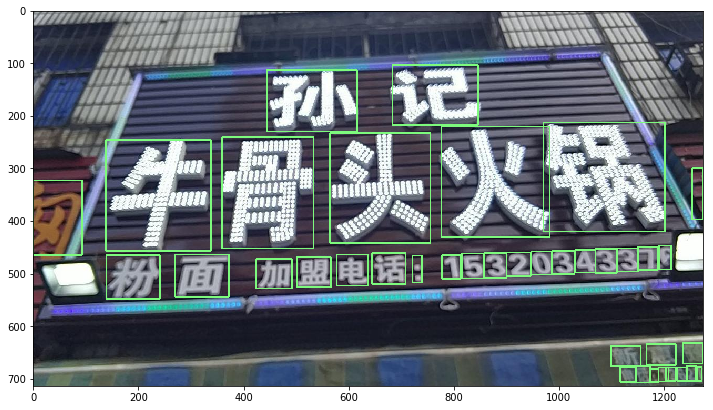

In [47]:
# the main loop
rand_idx = np.random.randint(len(image_paths))
print('rand_idx', rand_idx)

for image_path in image_paths[rand_idx:rand_idx+1]:
    image = cv2.imread(image_path)
    print(image.shape)
    assert not image is None
    direction = get_direction(image)
    raw_image = image.copy()
    print(image_path)

    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 

    # write the image with bounding boxes to file
    #cv2.imwrite(output_path + image_path.split('/')[-1], np.uint8(image))
    plt.figure(figsize=(12,12))
    plt.imshow(np.uint8(image)[..., ::-1])

# Predict on task 2 test data

In [ ]:
for image_path in tqdm(image_paths):
    raw_fn = Path(image_path).stem
    image = get_task2_masked_im(raw_fn)
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None
    direction = get_direction(image)
    image, ph, pw = pad_image(image) # pad image to (736,736) to prevent outlier zoomed-in text lines
    #print(image_path)
    root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2"

    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) == 0:
        print(f"No character is detected in {raw_fn}.")
        Path(f"{root_path}/{raw_fn}/img/").mkdir(parents=True, exist_ok=True)
        Path(f"{root_path}/{raw_fn}/coord/").mkdir(parents=True, exist_ok=True)
        cv2.imwrite(f"{root_path}/{raw_fn}/img/{raw_fn}_char_0.jpg", orig_image)
        np.save(f"{root_path}/{raw_fn}/coord/{raw_fn}_char_0.npy", np.array([0, 0, orig_w, orig_h]))
        continue
    boxes = convert_boxes_to_ndarray_coords(boxes)
    boxes = get_ordered_boxes(boxes, direction)
    crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)

## Inference on images that no character were detected with higher resolution.

In [16]:
fns_no_char_detected = ["test_ReCTS_task2_000097", "test_ReCTS_task2_000203", "test_ReCTS_task2_000504", "test_ReCTS_task2_001229", "test_ReCTS_task2_001363", "test_ReCTS_task2_001574", "test_ReCTS_task2_001654", "test_ReCTS_task2_001748", "test_ReCTS_task2_001925", "test_ReCTS_task2_002042", "test_ReCTS_task2_002064", "test_ReCTS_task2_002092", "test_ReCTS_task2_002207", "test_ReCTS_task2_002977", "test_ReCTS_task2_003039", "test_ReCTS_task2_003166", "test_ReCTS_task2_003335", "test_ReCTS_task2_003555", "test_ReCTS_task2_004179", "test_ReCTS_task2_004268", "test_ReCTS_task2_004797", "test_ReCTS_task2_004934", "test_ReCTS_task2_005769", "test_ReCTS_task2_006496", "test_ReCTS_task2_006539", "test_ReCTS_task2_006683", "test_ReCTS_task2_006999", "test_ReCTS_task2_007077", "test_ReCTS_task2_007253", "test_ReCTS_task2_007270", "test_ReCTS_task2_007277", "test_ReCTS_task2_007353", "test_ReCTS_task2_007544", "test_ReCTS_task2_007555", "test_ReCTS_task2_008087", "test_ReCTS_task2_008338", "test_ReCTS_task2_008403", "test_ReCTS_task2_008898", "test_ReCTS_task2_008898", "test_ReCTS_task2_009235", "test_ReCTS_task2_009568", "test_ReCTS_task2_009578", "test_ReCTS_task2_009666", "test_ReCTS_task2_009912", "test_ReCTS_task2_010173", "test_ReCTS_task2_010502", "test_ReCTS_task2_010748",]

In [ ]:
for fn in tqdm(fns_no_char_detected):
    raw_fn = Path(fn).stem
    root_path = "D:/RRC2019_ReCTS/submissions/Task2/intermediate_data2_missed_images"
    
    # ====================
    #Step 1: resize (to 352)
    # ====================
    image = get_task2_masked_im(raw_fn)    
    long_side = np.max(image.shape[:2]) # =====
    resize_ratio = 352 / long_side # =====
    image = cv2.resize(image, (0,0), fx=resize_ratio, fy=resize_ratio) # =====  
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None        
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue
    
    # ====================
    #Step 2: perspective transform
    # ====================
    image = get_task2_masked_im(raw_fn, True) # =====
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue  
    
    # ====================
    #Step 3: perspective transform + resize (to 352)
    # ====================
    image = get_task2_masked_im(raw_fn, True) # =====
    long_side = np.max(image.shape[:2]) # =====
    resize_ratio = 352 / long_side # =====
    image = cv2.resize(image, (0,0), fx=resize_ratio, fy=resize_ratio) # =====  
    orig_image = image.copy()
    orig_h, orig_w, _ = orig_image.shape
    assert not image is None        
    direction = get_direction(image)
    image, ph, pw = pad_image(image)
    
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]    
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    boxes = get_thresholded_boxes(boxes, obj_thresh)
    boxes = remove_small_boxes(boxes, orig_h/8*orig_w/8)
    if len(boxes) != 0:
        boxes = convert_boxes_to_ndarray_coords(boxes)
        boxes = get_ordered_boxes(boxes, direction)
        crop_and_save_characters(boxes, orig_image, ph, pw, raw_fn, orig_h, orig_w, root_path)
        continue  
        
    print(f"No character is detected in {raw_fn}")

# Generate prediciton on Task 3 images

In [ ]:
image_paths = glob("D:/RRC2019_ReCTS/ReCTS_test_part1/ReCTS_test_part1/Task3_and_Task4/img/*.jpg") + glob("D:/RRC2019_ReCTS/ReCTS_test_part2-20190420/ReCTS_test_part2/task3_and_task4/img/*.jpg")

In [56]:
root_path = "D:/RRC2019_ReCTS/submissions/Task3/YOLOv3_bboxes"

for image_path in tqdm(image_paths):
    raw_fn = Path(image_path).stem
    image = cv2.imread(image_path)
    assert not image is None
    
    # predict the bounding boxes
    boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
    
    Path(f"{root_path}/{raw_fn}").mkdir(parents=True, exist_ok=True)
    with open(f"{root_path}/{raw_fn}/{raw_fn}.txt", 'w', encoding="utf-8_sig") as f:
        for box in boxes:
            if box.score >= obj_thresh:
                x0, y0, x1, y1 = box.xmin, box.ymin, box.xmax, box.ymax
                score = box.score
                f.write(str(x0) + "," + str(y0) + "," + str(x1) + "," + str(y1) + "," + str(score) + "\n")
    plt.imsave(fname=f"{root_path}/{raw_fn}/{raw_fn}.jpg", arr=np.uint8(image)[..., ::-1], format="jpg")

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:36<00:00,  4.45it/s]
